In [1]:
from include.road_process import Road
from include.cool_space import CoolSpace
from include.building import Building
import geopandas as gpd
import numpy as np
import rasterio
import matplotlib.pyplot as plt

In [2]:
directory_mac = "/Volumes/T7 Shield/TUD/Synthesis/cool_place/"
directory_win = "G:\\TUD\\Synthesis\\cool_place\\"

landuse_file = directory_mac + "ams_landuse_top10NL.shp"
road_file = directory_mac + "ams_roads_top10NL.shp"
building_file = directory_mac + "ams_buildings_bagplus.shp"
shadow_file = directory_mac + "testShadow.tif"

In [3]:
road = Road(gpd.read_file(road_file))

In [4]:
building = Building(gpd.read_file(building_file))

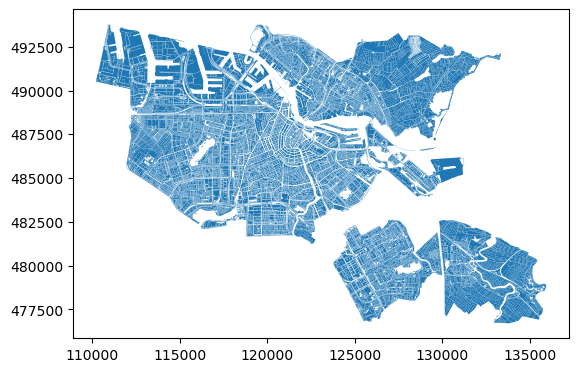

In [5]:
coolSpace = CoolSpace(gpd.read_file(landuse_file))
coolSpace.data.plot()
plt.show()

In [6]:
shadows = []
shadow_map1 = rasterio.open(shadow_file, crs=coolSpace.data.crs)
# shadow_map2 = rasterio.open(shadow_file, crs=coolSpace.data.crs)
shadows.append(shadow_map1)
# shadows.append(shadow_map2)

In [7]:
road.create_attribute('typeweg', 'buffer')
road.create_buffer('buffer')

Buffered geometry column created.


In [8]:
road.data.set_geometry("buffered", inplace=True)
coolSpace.clip(road.data)

In [9]:
building.create_buffer(4)
building.data.set_geometry("buffered", inplace=True)
coolSpace.clip(building.data, use_clip=True)

Buffered geometry column created.


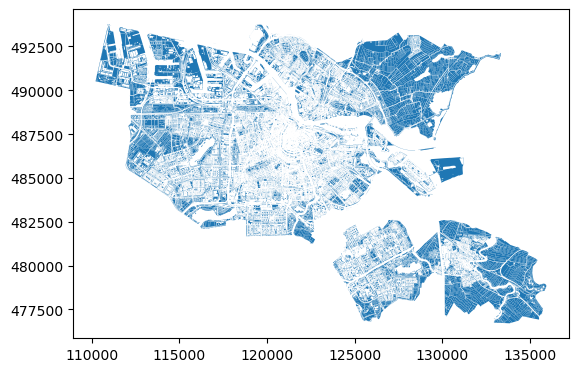

In [10]:
coolSpace.data["clipped"].plot()
plt.show()

In [11]:
coolSpace.calculate_shade(shadows, use_clip=True)

Processing raster 1/1
POLYGON ((120000 484980, 120000 486270, 118980 486270, 118980 484980, 120000 484980))
Geometry 2 is None, skipping.
Geometry 40 is None, skipping.
Geometry 41 is None, skipping.
Geometry 43 is None, skipping.
Geometry 55 is None, skipping.
Geometry 56 is None, skipping.
Geometry 72 is None, skipping.
Geometry 75 is None, skipping.
Geometry 76 is None, skipping.
Geometry 77 is None, skipping.
Geometry 87 is None, skipping.
Geometry 89 is None, skipping.
Geometry 90 is None, skipping.
Geometry 92 is None, skipping.
Geometry 138 is None, skipping.
Geometry 147 is None, skipping.
Geometry 155 is None, skipping.
Geometry 159 is None, skipping.
Geometry 161 is None, skipping.
Geometry 164 is None, skipping.
Geometry 165 is None, skipping.
Geometry 166 is None, skipping.
Geometry 168 is None, skipping.
Geometry 169 is None, skipping.
Geometry 172 is None, skipping.
Geometry 188 is None, skipping.
Geometry 206 is None, skipping.
Geometry 209 is None, skipping.
Geometry 23

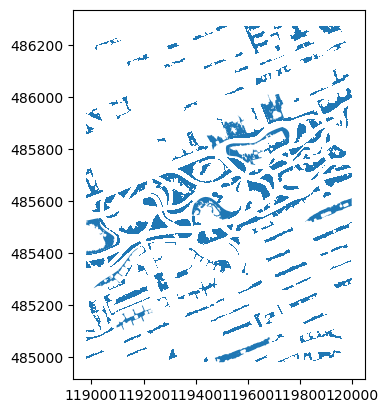

In [13]:
shadeGeom0 = coolSpace.get_shade_geometries(0)
shadeGeom0.plot()
plt.show()

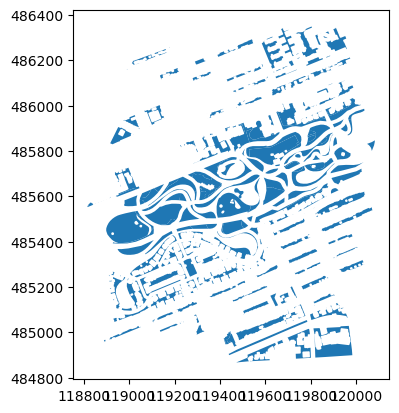

Index(['id', 'shadeArea0', 'shadeAvg0', 'clipped'], dtype='object')


In [14]:
coolGeom0 = coolSpace.get_cool_spaces()
coolGeom0.geometry.plot()
plt.show()

print(coolGeom0.columns)

In [15]:
non_none_rows = coolSpace.data[coolSpace.data["shadeGeom0"].notna()]
geom_types = non_none_rows['shadeGeom0'].apply(lambda geom: geom.geom_type)
print(geom_types.value_counts())
print(non_none_rows["shadeGeom0"].area.max(), non_none_rows["shadeGeom0"].area.min())

Polygon         104
MultiPolygon     45
Name: count, dtype: int64
5229.25 206.75


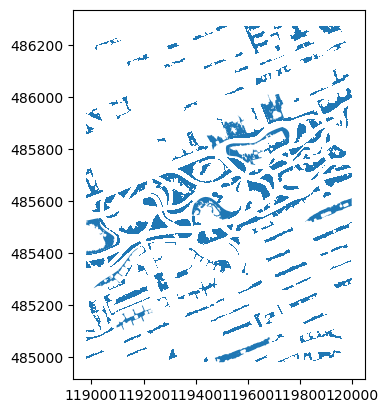

In [16]:
coolSpace.data["shadeGeom0"].plot()
plt.show()

In [17]:
coolSpace_shadeGeoms = gpd.GeoDataFrame(coolSpace.data, geometry='shadeGeom0', crs=coolSpace.data.crs)
coolSpace_shadeGeoms.drop(columns=['geometry', 'clipped'], inplace=True)
coolSpace_shadeGeoms['shadeArea0'] = coolSpace_shadeGeoms['shadeArea0'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))

# coolSpace_shadeGeoms.to_file(directory_mac + "shadeGeom0.shp") # somehow this doesn't work, it saves polygons as line-strings.
coolSpace_shadeGeoms.to_file(directory_mac + "shadeGeom0.gpkg", driver="GPKG")

In [20]:
coolSpace_clipped = gpd.GeoDataFrame(coolSpace.data, geometry='clipped', crs=coolSpace.data.crs)
coolSpace_clipped.drop(columns=["geometry", "shadeGeom0"], inplace=True)
coolSpace_clipped['shadeArea0'] = coolSpace_clipped['shadeArea0'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))
coolSpace_clipped.to_file(directory_mac + "test1.shp")

In [22]:
coolSpace_origin = gpd.GeoDataFrame(coolSpace.data, geometry='geometry', crs=coolSpace.data.crs)
coolSpace_origin.drop(columns=["clipped", "shadeGeom0"], inplace=True)
coolSpace_origin['shadeArea0'] = coolSpace_origin['shadeArea0'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))
coolSpace_origin.to_file(directory_mac + "test2.shp")

In [23]:
coolGeom0['shadeArea0'] = coolGeom0['shadeArea0'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))
coolGeom0.to_file(directory_mac + "coolGeom0.shp")